# Chapter 6: A Journey Into Sound

(note: uses PyTorch 1.6 and torchaudio 0.6.0)

Download and extract the ESC-50 files from https://github.com/karolpiczak/ESC-50#download

In [1]:
# !pip install librosa

In [2]:
import IPython.display as display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchaudio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms
from typing import Tuple

In [3]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses        

## ESC-50 Dataset & DataLoaders

In [4]:
# git clone https://github.com/karoldvl/ESC-50

In [5]:
class ESC50(Dataset):
    def __init__(self, path: str):
        files = Path(path).glob('*.wav')
        self.items = [(str(f), f.name.split("-")[-1].replace(".wav", "")) for f in files]
        self.length = len(self.items)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        try:
            filename, label = self.items[index]
            audioTensor, rate = torchaudio.load(filename)
            return audioTensor, int(label)
        except Exception as e:
            # Handle exceptions, e.g., log the error or return a default value
            print(f"Error loading data at index {index}: {e}")
            return None

    def __len__(self) -> int:
        return self.length

In [6]:
# Define the path to the ESC-50 dataset
PATH_TO_ESC50 = Path.cwd() / 'ESC-50/test'

# Create an instance of the ESC50 dataset
test_esc50 = ESC50(PATH_TO_ESC50)

# Access an item from the dataset
tensor, label = test_esc50[0]

In [7]:
tensor

tensor([[-6.1035e-05, -6.1035e-05,  6.1035e-05,  ..., -1.9592e-01,
         -1.7294e-01, -9.9823e-02]])

In [8]:
label

22

In [9]:
device="mps"
bs=8
PATH_TO_ESC50 = Path.cwd() / 'ESC-50'

train_esc50 = ESC50(PATH_TO_ESC50 / "train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "valid")
test_esc50  = ESC50(PATH_TO_ESC50 / "test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size = bs, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size = bs, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_esc50, batch_size = bs, shuffle = True)

## M5-based CNN AudioNet

In [10]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [11]:
device

'mps'

In [12]:
audionet = AudioNet()
audionet.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

## Find learning rate & train

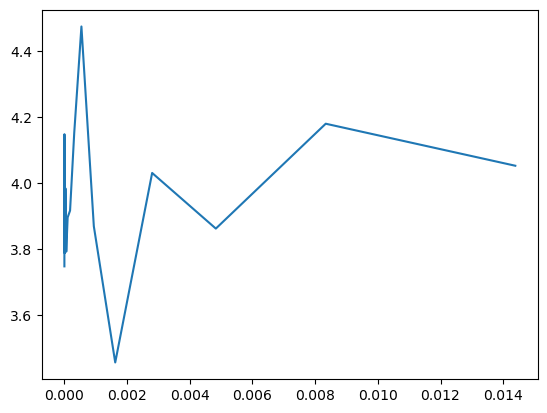

In [13]:
torch.save(audionet.state_dict(), "audionet.pth")
optimizer = optim.Adam(audionet.parameters(), lr=0.001)
logs,losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)

plt.plot(logs,losses)

In [14]:
lr = 1e-5
audionet.load_state_dict(torch.load("audionet.pth"))
optimizer = optim.Adam(audionet.parameters(), lr=lr)

In [15]:
train(audionet, optimizer, torch.nn.CrossEntropyLoss(),train_loader, valid_loader, epochs=20, device=device)

/var/folders/74/rcykwfcx5bq6vwfd93bqrhgm0000gn/T/ipykernel_25490/2411585731.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 4.00, Validation Loss: 3.98, accuracy = 0.00
Epoch: 2, Training Loss: 3.83, Validation Loss: 4.02, accuracy = 0.01
Epoch: 3, Training Loss: 3.72, Validation Loss: 4.01, accuracy = 0.01
Epoch: 4, Training Loss: 3.63, Validation Loss: 3.99, accuracy = 0.01
Epoch: 5, Training Loss: 3.59, Validation Loss: 4.01, accuracy = 0.01
Epoch: 6, Training Loss: 3.47, Validation Loss: 3.99, accuracy = 0.01
Epoch: 7, Training Loss: 3.39, Validation Loss: 3.99, accuracy = 0.00
Epoch: 8, Training Loss: 3.32, Validation Loss: 3.99, accuracy = 0.01
Epoch: 9, Training Loss: 3.26, Validation Loss: 3.99, accuracy = 0.01
Epoch: 10, Training Loss: 3.18, Validation Loss: 3.98, accuracy = 0.01
Epoch: 11, Training Loss: 3.13, Validation Loss: 3.99, accuracy = 0.01
Epoch: 12, Training Loss: 3.09, Validation Loss: 3.99, accuracy = 0.01
Epoch: 13, Training Loss: 3.03, Validation Loss: 3.97, accuracy = 0.01
Epoch: 14, Training Loss: 3.00, Validation Loss: 3.99, accuracy = 0.01
Epoch: 15, Trai

## Using Spectrograms

In [16]:
sample_data, sr = librosa.load("ESC-50/train/4-189828-A-22.wav", sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
# Log scale is able to distinguish between different frequencies better
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

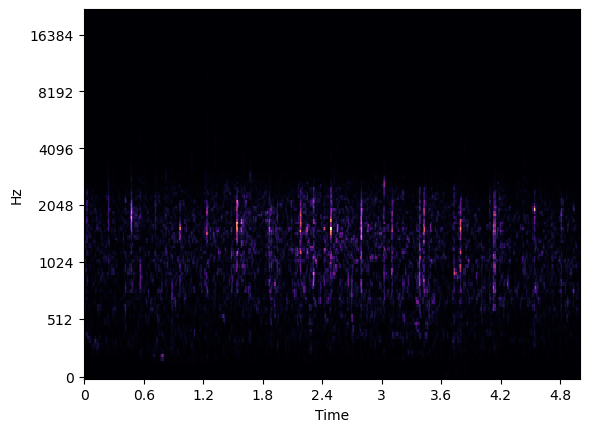

In [17]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

In [18]:
# def precompute_spectrograms(path, dpi=50):
#     files = Path(path).glob('*.wav')
#     for filename in files:
#         audio_tensor, sr = librosa.load(filename, sr=None)
#         spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr=sr)
#         log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#         librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
#         plt.gcf().savefig("{}{}_{}.png".format(filename.parent,dpi,filename.name), dpi=dpi)
# 
# PATH_ESC50_TRAIN = PATH_TO_ESC50 / "train"
# PATH_ESC50_VALID = PATH_TO_ESC50 / "valid"
# 
# precompute_spectrograms(PATH_ESC50_TRAIN)
# precompute_spectrograms(PATH_ESC50_VALID)

In [19]:
PATH_ESC50_TRAIN = PATH_TO_ESC50 / "train"
PATH_ESC50_VALID = PATH_TO_ESC50 / "valid"

In [20]:
class PrecomputedESC50(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

## Pretrained ResNet50

In [21]:
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,50))

/Users/saadnaeem/anaconda3/envs/learn-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saadnaeem/anaconda3/envs/learn-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
esc50pre_train = PrecomputedESC50(PATH_ESC50_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50pre_valid = PrecomputedESC50(PATH_ESC50_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, bs, shuffle=True)
esc50_val_loader = torch.utils.data.DataLoader(esc50pre_valid, bs, shuffle=True)

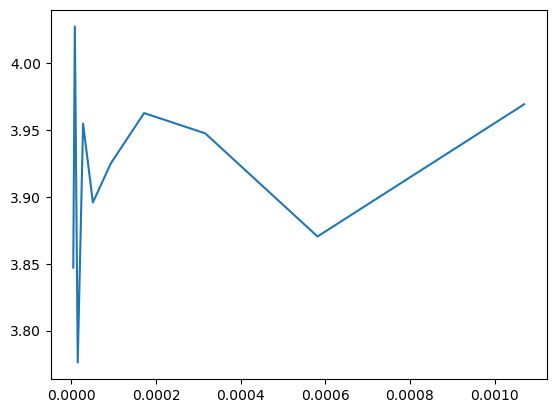

In [23]:
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, esc50_train_loader, device=device)
plt.plot(logs, losses)

In [24]:
!export PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 

In [25]:
spec_resnet.load_state_dict(torch.load("spec_resnet.pth"))
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}
                        ], lr=1e-2)

# train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True

train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

/var/folders/74/rcykwfcx5bq6vwfd93bqrhgm0000gn/T/ipykernel_25490/2411585731.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 3.88, Validation Loss: 3.86, accuracy = 0.05
Epoch: 2, Training Loss: 3.69, Validation Loss: 3.77, accuracy = 0.13
Epoch: 3, Training Loss: 3.43, Validation Loss: 3.69, accuracy = 0.11
Epoch: 4, Training Loss: 3.22, Validation Loss: 3.60, accuracy = 0.14
Epoch: 5, Training Loss: 3.02, Validation Loss: 3.57, accuracy = 0.17


## Data Augmentation

In [26]:
class ESC50WithPitchChange(Dataset):

    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(f,f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
        self.E = torchaudio.sox_effects.SoxEffectsChain()
        self.E.append_effect_to_chain("pitch", [0.5])
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        self.E.set_input_file(filename)
        audio_tensor, sample_rate = self.E.sox_build_flow_effects()
        return audio_tensor, label
        
    def __len__(self):
        return self.length

In [27]:
class FrequencyMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the frequency 
            mask is to be applied.

        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
        start = random.randrange(0, tensor.shape[2])
        end = start + random.randrange(1, self.max_width)
        if self.use_mean:
            tensor[:, start:end, :] = tensor.mean()
        else:
            tensor[:, start:end, :] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')

        return format_string

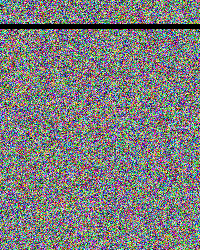

In [28]:
transforms.Compose([FrequencyMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3,250,200))

In [29]:
class TimeMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     TimeMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the time mask 
            is to be applied.

        Returns:
            Tensor: Transformed image with Time Mask.
        """
        start = random.randrange(0, tensor.shape[1])
        end = start + random.randrange(0, self.max_width)
        if self.use_mean:
            tensor[:, :, start:end] = tensor.mean()
        else:
            tensor[:, :, start:end] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')
        return format_string

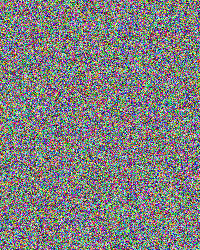

In [30]:
transforms.Compose([TimeMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3,250,200))

In [31]:
class PrecomputedTransformESC50(Dataset):
    def __init__(self, path, max_freqmask_width, max_timemask_width, use_mean=True, dpi=50):
        files = Path(path).glob('{}*.wav.png'.format(dpi))
        self.items = [(f,f.name.split("-")[-1].replace(".wav.png","")) for f in files]
        self.length = len(self.items)
        self.max_freqmask_width = max_freqmask_width
        self.max_timemask_width = max_timemask_width
        self.use_mean = use_mean
        self.img_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomApply([FrequencyMask(self.max_freqmask_width, self.use_mean)], p=0.5),
            transforms.RandomApply([TimeMask(self.max_timemask_width, self.use_mean)], p=0.5)
])
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename)
        return (self.img_transforms(img), label)
        
    def __len__(self):
        return self.length